In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import *
import time
import ott

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from entot.models.utils import MLP, MLP_FM

from ott.solvers.nn.models import ModelBase, NeuralTrainState
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
import pandas as pd
from entot.models.gen_model import OTFlowMatching, MLP_FM, MLP_FM2, MLP_FM3, MLP_no_noise, OriginalFlowMatching, MLP_FM_VAE

2023-07-18 11:58:56.373905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from entot.models.utils import MixtureNormalSampler
source = MixtureNormalSampler([0], 1,  0.5, batch_size=2048)(jax.random.PRNGKey(0))
target = MixtureNormalSampler([-1.0,1.0], 1,  0.1, batch_size=2048)(jax.random.PRNGKey(0))

<Axes: ylabel='Density'>

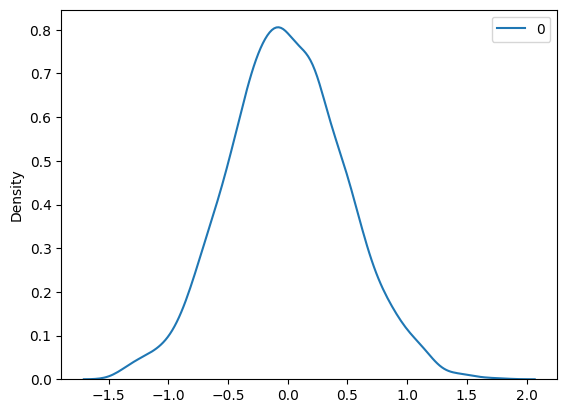

In [5]:
sns.kdeplot(source)

<Axes: ylabel='Density'>

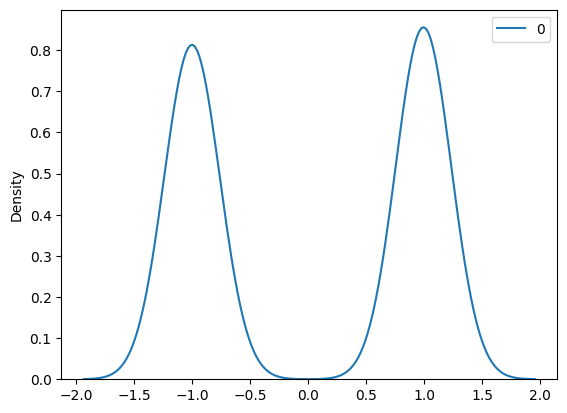

In [6]:
sns.kdeplot(target)

In [7]:
#neural_net = MLP_FM3(1, 32, 32, 32, n_frequencies=10)
#neural_net = MLP_FM(1, [64, 64, 64, 64], n_frequencies=1)
neural_net = MLP_FM_VAE(1, 32, 32, 32)


In [13]:
#cosine_decay_scheduler = optax.cosine_decay_schedule(1e-3, decay_steps=1_000, alpha=0.95)
#optimizer = optax.adamw(learning_rate=cosine_decay_scheduler)
#latent_to_data_solver = ott.solvers.linear.sinkhorn.Sinkhorn()
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()

otfm = OTFlowMatching(neural_net, ot_solver=ot_solver, epsilon=1e-3, input_dim=1, output_dim=1, iterations=1_000, noise_std=0.1, scale_cost=1.0)

In [14]:
otfm.iterations = 3000
otfm(source, target, 256, 256)

100%|██████████| 3000/3000 [04:37<00:00, 10.82it/s]


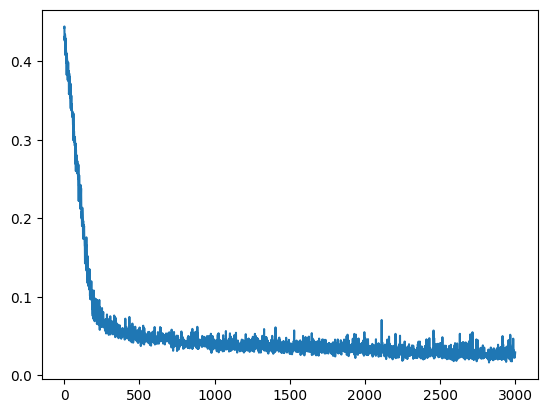

In [15]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

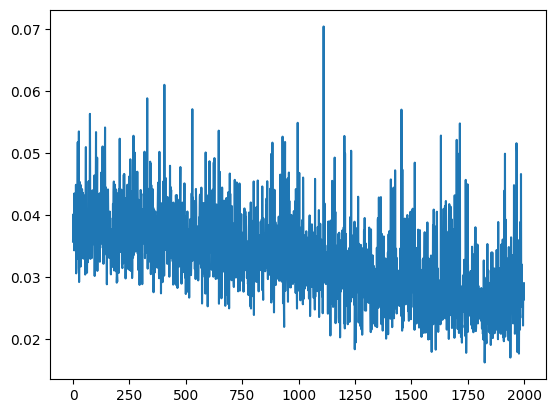

In [16]:
plt.plot(np.arange(len(otfm.metrics["loss"][1000:])), otfm.metrics["loss"][1000:])

In [57]:
res,_ = otfm.transport(source, seed=1)
#sns.kdeplot(res[0,...])

In [17]:
import diffrax
from functools import partial
rng = jax.random.PRNGKey(0)

latent_shape = (len(source),)
latent_batch = otfm.noise_fn(rng, shape=latent_shape) * otfm.noise_std

apply_fn_partial = partial(
    otfm.state_neural_net.apply_fn, condition=source,latent=latent_batch
)
apply_fn_partial2 = lambda *args, **kwargs: apply_fn_partial(*args, **kwargs)[0]
_, mu_0, sigma_0 = otfm.state_neural_net.apply_fn({"params": otfm.state_neural_net.params}, condition=source, t=0, latent=latent_batch, flow=jnp.zeros_like(latent_batch))


In [18]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(lambda t, y, args: apply_fn_partial2({"params": otfm.state_neural_net.params}, t=t, flow=y)),
    diffrax.Tsit5(),
    t0=0,
    t1=1,
    dt0=None,
    y0=mu_0 + sigma_0 * latent_batch,#y0,#latent_batch,  
    stepsize_controller= diffrax.PIDController(rtol=1e-3, atol=1e-6),
)

<Axes: ylabel='Density'>

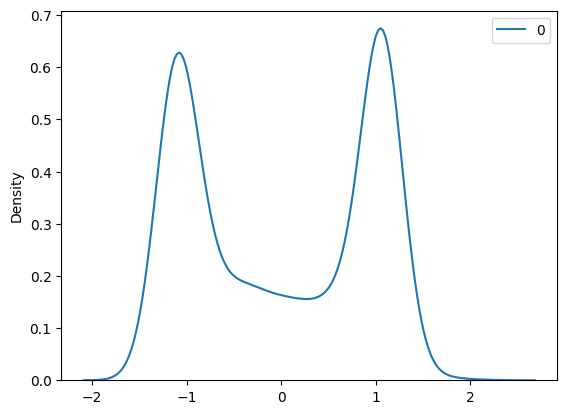

In [19]:
sns.kdeplot(solution.ys[0,...])

In [58]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(lambda t, y, args: apply_fn_partial2({"params": otfm.state_neural_net.params}, t=t, flow=y)),
    diffrax.Tsit5(),
    t0=0,
    t1=1,
    dt0=None,
    y0=mu_0,#y0,#latent_batch,  
    stepsize_controller= diffrax.PIDController(rtol=1e-3, atol=1e-6),
)

In [21]:
solution.ys.shape

(1, 2048, 1)

<Axes: ylabel='Density'>

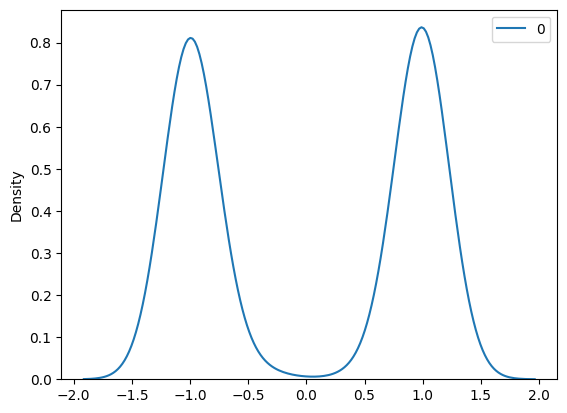

In [59]:
sns.kdeplot(solution.ys[0,...])
#sns.kdeplot(res[0,...])

In [20]:
source_repeat = jnp.ones((1,)) * 0.4
source_repeat = jnp.repeat(source_repeat, 100)[:, None]

rng = jax.random.PRNGKey(0)

latent_shape = (len(source_repeat),)
latent_batch = otfm.noise_fn(rng, shape=latent_shape) * otfm.noise_std

apply_fn_partial = partial(
    otfm.state_neural_net.apply_fn, condition=source_repeat,latent=latent_batch
)
apply_fn_partial2 = lambda *args, **kwargs: apply_fn_partial(*args, **kwargs)[0]
_, mu_0, sig_0 = otfm.state_neural_net.apply_fn({"params": otfm.state_neural_net.params}, condition=source_repeat, t=0, latent=latent_batch, flow=jnp.zeros_like(latent_batch))


In [22]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(lambda t, y, args: apply_fn_partial2({"params": otfm.state_neural_net.params}, t=t, flow=y)),
    diffrax.Tsit5(),
    t0=0,
    t1=1,
    dt0=None,
    y0=mu_0 + sig_0 * latent_batch,#y0,#latent_batch,  
    stepsize_controller= diffrax.PIDController(rtol=1e-3, atol=1e-6),
)

<Axes: ylabel='Density'>

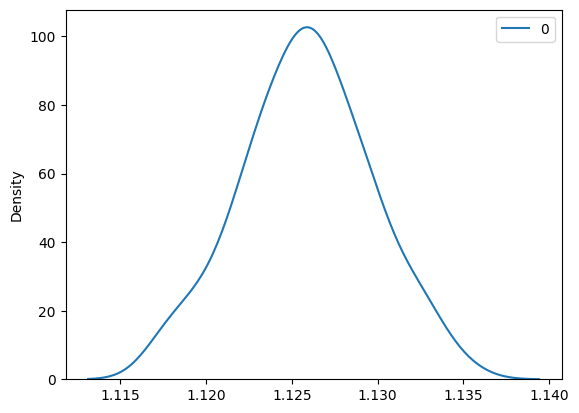

In [23]:
sns.kdeplot(solution.ys[0,...])

<Axes: ylabel='Density'>

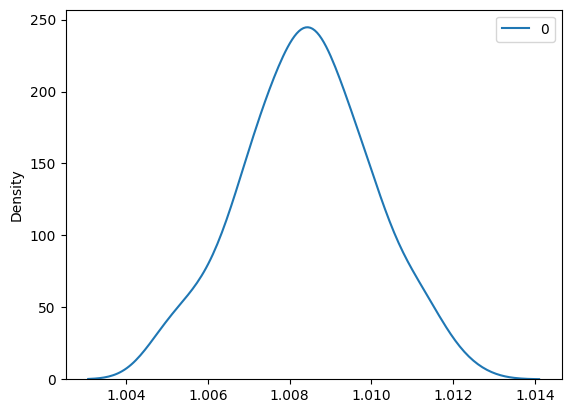

In [67]:
sns.kdeplot(solution.ys[0,...])

In [24]:
ts = np.linspace(0,1,30)
_, solution = otfm.transport(source_repeat, seed=0, diffeqsolve_kwargs={"saveat":diffrax.SaveAt(ts=ts)})

In [25]:
inds = jax.random.choice(jax.random.PRNGKey(0), jnp.arange(len(solution.ys)), (30,))
tracks = solution.ys[:,inds,0]

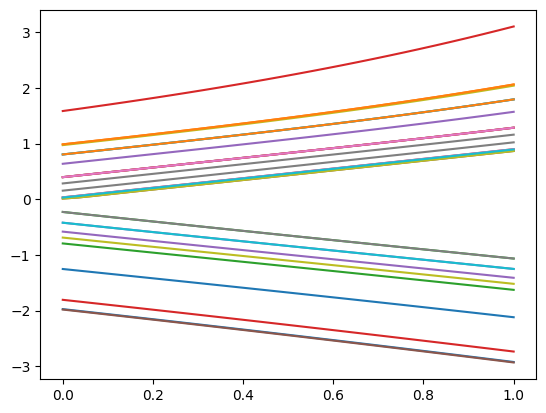

In [26]:
plt.plot(ts, tracks)
plt.show()

In [35]:
t_vec = ts[1:] - ts[:-1]
t_vector = np.tile(t_vec[:, None], (1, tracks.shape[-1]))
y_vector = tracks[1:, ...] - tracks[:-1,...]
t_augmented = np.tile(ts[:, None], (1, tracks.shape[-1]))[:-1, ...]

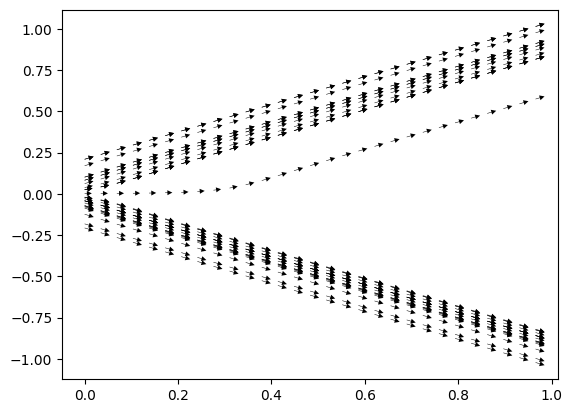

In [36]:
plt.quiver(t_augmented, tracks[:-1], t_vector, y_vector, width=1e-3, headwidth=10, headlength=10, headaxislength=10, angles="xy")